# Predicción del resultado del tratamiento de pacientes con diabetes

## Entendimiento del problema y de los datos

Las readmisiones o reingresos hospitalarios se han convertido en un tema de discusión a nivel mundial, puesto que principalmente representan costos e impactan las tasas de morbilidad y de mortalidad. A través de varios estudios se ha tratado este tema de diferentes formas, entre ellas, a través de modelos que permitan predecir los reingresos hospitalarios y así mismo crear estrategias para prevenirlos o priorizar aquellos pacientes de acuerdo a su estado de salud.

En este caso, se cuenta con un dataset que representa 10 años (1999-2008) de atención clínica en 130 hospitales y redes integradas de prestación de servicios de EE. UU. Incluye más de 50 funciones que representan los resultados del paciente y del hospital. Se extrajo información de la base de datos para los ingresos que cumplieron con los siguientes criterios.


**1.** Es un ingreso hospitalario (una admisión hospitalaria).

**2.** Es un ingreso diabético, es decir, durante el cual se ingresó al sistema cualquier tipo de diabetes como diagnóstico.

**3.** La duración de la estancia fue de al menos 1 día y como máximo 14 días.

**4.** Se realizaron pruebas de laboratorio durante la estancia.

**5.** Se administraron medicamentos durante la estancia.


Los datos contienen atributos tales como número de paciente, raza, sexo, edad, tipo de admisión, tiempo en el hospital, especialidad médica del médico que lo admite, número de pruebas de laboratorio realizadas, resultado de la prueba de HbA1c, diagnóstico, cantidad de medicación, medicamentos para diabéticos, cantidad de pacientes ambulatorios , visitas hospitalarias y urgentes en el año anterior a la hospitalización, etc. Para cada registro existe uno de los siguientes resultados:


**1.** No readmisión.

**2.** Readmisión en menos de 30 días (esta situación no es buena, porque existe la posibilidad de que el tratamiento aplicado no fue apropiado).

**3.** Readmisión después de 30 días (esta situación tampoco es buena, sin embargo, la razón podría estar relacionada con el estado del paciente).

===========================================================================================================================

Se propone entonces a través de un modelo de clasificación, predecir ese resultado posterior al tratamiento de pacientes con diabetes que ingresan a los hospitales. De acuerdo a lo expresado en el artículo  “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records” (citado en el repositorio del dataset), se está principalmente interesados en los factores que provocan la readmision (o reingreso) temprana. Para ello, entonces, **se define la variable de respuesta como readmitido (valor 1), si el paciente fue reingresado en menos de 30 días después de dado de alta y no readmitido (valor 0) si tuvo readmisión después de 30 días o no tuvo readmisión.**

A continuación se realiza la exploración y entendimiento de datos:


In [373]:
#Cargue de librerías
import pandas as pd
import numpy as np

import sweetviz as sv

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.

###### módulos de ML
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score

from scipy import stats
from sklearn.metrics import roc_curve, mean_squared_error, roc_auc_score, precision_score 
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

import time

#from scipy import interp

#pd.options.mode.chained_assignment = None       # Fix for pandas warning

# Sklearn imports

#from sklearn.model_selection import (
#        train_test_split,
#        learning_curve,
#        StratifiedKFold,
#        cross_val_score
#        )

#from sklearn.metrics import (
#        roc_auc_score,
#        roc_curve,
        # precision_recall_curve,
#        confusion_matrix,
#        auc,
#        cohen_kappa_score,
#        accuracy_score,
#        precision_score,
#        recall_score,
#        classification_report
#        )


#from hyperopt import hp, STATUS_OK, fmin, tpe, Trials

In [289]:
#Cargue del dataset
data = pd.read_csv('dataset_diabetes/diabetic_data.csv')

In [290]:
print('Número de registros:', data.shape[0],'::::','Número de columnas:', data.shape[1])
data.head()

Número de registros: 101766 :::: Número de columnas: 50


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [291]:
#Registros unicos?
print('Número de registros de ingresos hospitalarios únicos:', len(data.encounter_id.unique()))
print('Número de registros de pacientes únicos:', len(data.patient_nbr.unique()))


Número de registros de ingresos hospitalarios únicos: 101766
Número de registros de pacientes únicos: 71518


Contamos con un dataset de 101.766 registros correspondientes a cada uno de los ingresos hospitalarios registrados en el periodo de 10 años, como se identifica, un paciente puede presentar duplicidad en los datos, pues en esa historia considerada, puede tener varios ingresos (y más aún cuando son readmisiones). **Por lo tanto debemos tener en cuenta más adelante** para el modelo de clasificación la consideración de registros únicos por paciente, puesto que si se realiza por ingreso hospitalario, tendríamos ruido, ya que la información es la misma en la mayoría de variables para un mismo paciente.

In [292]:
# Se identifica el tipo de dato para cada una de las variables.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

De acuerdo al diccionario de datos identificamos variables que se han leído sin el tipo correspondiente. Por ejemplo, el tipo de admisión (admission_type_id) o la disposición cuando se dió de alta (discharge_disposition_id) son nominales.

In [293]:
#Lista de variables para convertir a str
var_type_str = ['encounter_id','patient_nbr','admission_type_id','discharge_disposition_id',
                'admission_source_id']

In [294]:
for i in var_type_str:
    data[i] = data[i].astype(str)

Se utiliza a continuación una librería (sweetviz) para realizar análisis exploratorio de datos en un reporte

In [95]:
reporte_eda = sv.analyze(data)

:FEATURES DONE:                    |█████████████████████| [100%]   00:50  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   03:46  -> (00:00 left)


Creating Associations graph... DONE!


In [96]:
#Muestra el reporte en un html
reporte_eda.show_html('reporte_data_diabetes.html')

Report reporte_data_diabetes.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


#### Evaluación de NA's

Luego de revisar el reporte se puede ver algunas inconsistencias o datos faltantes en varios campos. **Raza (race)** tiene 2.273 (2%) de missing, **Peso (weight)** 98.569 (97%), **Payer code** 40.256 (40%), **Especialidad médica (medical_specialty)** 49.949 (49%) y los campos de los **diagnósticos (diag_1, diag_2, diag_3)** con porcentajes muy pequeños. Además de missing se tienen algunas variables que debemos tener en cuenta en su uso para la modelación como la medicación de **examida (examide)** y **citoglipton** que en el 100% de los registros sucede que estas medicaciones No fueron prescritas a los pacientes.

## Preparación de datos

Luego de haber realizado entendimiento de los datos y tener una idea de las variables, las inconsistencias y tratamiento que se debe dar al dataset, se procede a preparar esos datos y dejarlos listos para la etapa de modelación

Para el caso de los pacientes duplicados por sus múltiples ingresos, me baso en las consideraciones de los investigadores en el artículo médico relacionado, puesto que se puede considerar como los expertos del tema y esas consideraciones son útiles para alinear la ciencia de datos con el objetivo que se busca lograr. Por lo tanto se considera el primer registro para cada paciente como el ingreso o admisión principal.

In [295]:
# Ejemplo de un paciente (24746013) con dos admisiones 
data[data.patient_nbr == '24746013'].head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
15077,58224612,24746013,Caucasian,Female,[80-90),?,5,4,17,12,?,?,25,1,24,0,0,0,250.1,599,486,8,>300,None,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
16076,60786828,24746013,Caucasian,Female,[80-90),?,5,11,17,5,?,Family/GeneralPractice,22,0,10,0,0,1,151,599,250.2,5,>300,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO


In [296]:
# Se dejan registros únicos
data.drop_duplicates(subset = ['patient_nbr'], keep = 'first', inplace = True)

Entonces, tenemos un dataset con 71.518 registros, ya con pacientes únicos, sin el problema de duplicidad por múltiples ingresos hospitalarios.

In [297]:
print('Número de registros:', data.shape[0],'::::','Número de columnas:', data.shape[1])

Número de registros: 71518 :::: Número de columnas: 50


Adicionalmente, de acuerdo a las necesidades de los investigadores médicos, no se tienen en cuenta los pacientes que fallecieron o que se encuentran en hospicio, es decir, que ya están en la etapa final, ya sin tratamiento. Esto también para dejar de lado posible ruido o evitar sesgo en el análisis

In [298]:
data = data[~data.discharge_disposition_id.isin(['11','19','20','21','13','14'])]

In [299]:
print('Número de registros:', data.shape[0],'::::','Número de columnas:', data.shape[1])

Número de registros: 69973 :::: Número de columnas: 50


#### Creación de variable de respuesta (target)

In [300]:
# Resultados de readmisión o no, después del tratamiento de los pacientes que ingresaron
data.readmitted.value_counts()

NO     41474
>30    22222
<30     6277
Name: readmitted, dtype: int64

Como se definió en el entendimiento del problema, se ajusta la variable de respuesta como readmitido (valor 1), si el paciente fue reingresado en menos de 30 días después de dado de alta y no readmitido (valor 0) si tuvo readmisión después de 30 días o no tuvo readmisión.

In [301]:
data['readmitted'] = np.where(data['readmitted'] == '<30', 1, 0)

In [302]:
data.readmitted.value_counts()

0    63696
1     6277
Name: readmitted, dtype: int64

In [303]:
data.readmitted.value_counts()/len(data)*100

0    91.029397
1     8.970603
Name: readmitted, dtype: float64

Como se oberva, aprox. **el 9%** de la base que se tiene hasta este momento, correpsonde a pacientes que presentaron readmisión temprana o en menos de 30 días, después de haberse dado de alta por ingreso hospitalario. Esto ya nos evidencia que tendremos datos desbalanceados, para tener en cuenta en la modelación. 

#### Tratamiento de NA's y valores inconsistentes

En primer lugar para la variable **Peso (weight)**, con un muy alto porcentajes de missing data, se procede a no tener en cuenta este campo. También el campo de **payer_code**, con aprox. 50% de missing, que se refiere a la empresa o entidad de seguros médicos que pagó el tratamiento, puesto que son muchas categorías y en el entendimiento del problema, se podría considerar que no tiene un sentido para nuestro objetivo. Las medicaciones de **examide** y **citoglipton** que en el 100% de los pacientes no fueron prescritas estas medicaciones, también se proceden a descartarse de la base final.

In [304]:
drop_vars = ['encounter_id', 'weight', 'payer_code', 'examide', 'citoglipton']

In [305]:
data.drop(drop_vars, axis = 1, inplace = True)

#### Feature Engineering

Para las variables:
1. **Raza**: Se dejará las categorías Caucasian, AfricanAmerican, Otros (Hispani y Asian incluídos) y los NAs se categorizan como missing.
2. **Género**: Se deja tal cual, pero hay 3 valores inválidos (Unknown/Invalid), estos se dejan como NA's por ser casi nula esa proporción.
3. **Edad**: Dado que está por rangos de edad de 10 años, se podrían agrupar un poco más para reducir la cantidad de categorías y así mismo, agruparlas siguiendo la distribución vista anteriormente durante el entendimiento de los datos. Entonces se propone agrupar los menores de 40, entre 40 y 60, 60 y  80 y 80 o más años.
4. **Tipo de admisión**: Se dejan las categorías más importantes como Emergency, Elective y los demás se clasifican como Otros (Other). 
5. **Tipo de alta**: Se maneja la categoría más frecuente que es despachado a casa (discharged_home) y otros (other). 
6. **Origen de la admisión**: Se dejan dos categorías más frecuentes, desde sala de emergencias (Emergency_room) y transferencia desde clínica o referencia médica (Phys_clinic_referral). Para las demás categorías se consideran como otras (Other).
7. **Especialidad médica**: definitivamente no se tiene en cuenta por el gran número de categorías que contiene, incluso ninguna especialidad tiene frecuencia mayor que los missing (48%).
8. **Diagnósticos**: Estos campos de los diagnósticos son reclasificados de acuerdo a los grupos de  diagnósticos presentados por los investigadores médicos en el artículo. Dejando los de mayor frecuencia.
9. **Resultados de la prueba de glucosa y A1c**: se procede a dejar los resultados de estas pruebas tal como están, puesto que los resultados y los rangos establecidos por los médicos son interesantes para ver como puede influir en el análisis, por ejemplo, de un resultado normal a uno que sobrepasa ciertos niveles.
10. **Medicamentos**: Se conservan las categorías, a pesar de que para algunos sean muy pequeñas las frecuencias (casi nulas) para aquellos en los que cambiaron las dosificaciones, o se mantuvieron o en definitiva no fue prescrito el medicamento, porque con las iteraciones sería interesante ver si son importantes estas condiciones para el modelo.
11. **Cambios en medicaciones de diabetes**: Se recodifica la variable con 1 si se presentaron cambios en los medicamentos de diabetes y 0 si no.
11. **Medicaciones para diabetes**: Se recodifica la variable con 1 si se prescribieron medicamentos de diabetes y 0 si no.

In [306]:
data['race'] = np.where(data['race'].isin(['Hispanic', 'Other', 'Asian']), 'Other', data['race'])
data['race'] = np.where(data['race'] == '?', 'missing', data['race'])

In [307]:
data['gender'] = np.where(data['gender'] == 'Unknown/Invalid', np.nan, data['gender'])

In [308]:
data['age'] = np.where(data['age'].isin(['[0-10)','[10-20)','[20-30)','[30-40)']), 'menores_40', data['age'])
data['age'] = np.where(data['age'].isin(['[40-50)','[50-60)']), 'entre_40_60', data['age'])
data['age'] = np.where(data['age'].isin(['[60-70)','[70-80)']), 'entre_60_80', data['age'])                       
data['age'] = np.where(data['age'].isin(['[80-90)','[90-100)']), '80_mas', data['age']) 

In [309]:
data['admission_type_id'] = np.where(data['admission_type_id'].isin(['1','2']), 'Emergency', data['admission_type_id'])
data['admission_type_id'] = np.where(data['admission_type_id'] == '3', 'Elective', data['admission_type_id'])
data['admission_type_id'] = np.where(data['admission_type_id'].isin(['4','5','6','7','8']), 'Other', data['admission_type_id'])

In [310]:
data['discharge_disposition_id'] = np.where(data['discharge_disposition_id'] == '1', 'Discharged_home', 'Other')

In [311]:
data['admission_source_id'] = np.where(data['admission_source_id'] == '7', 'Emergency_room', data['admission_source_id'])
data['admission_source_id'] = np.where(data['admission_source_id'] == '1', 'Phys_clinic_referral', data['admission_source_id'])
data['admission_source_id'] = np.where(data['admission_source_id'].isin(['Emergency_room','Phys_clinic_referral']), data['admission_source_id'], 'Other')


In [312]:
#Definimos la misma función para recategorizar los campos diag_1, diag_2 y diag_3
def categ_diagnosticos(df):
    
    #Se listan campos que se quieren categorizar
    campos_diag = ['diag_1','diag_2','diag_3']
    
    for j in campos_diag:
        
        #categorias
        diagnosticos = ['circulatory','respiratory','digestive', 'diabetes', 'injury', 'musculoskeletal','genitourinary']
        
        condiciones = [ (((df[j] >= '390') & (df[j] <= '459')) | (df[j] == '785')),
           (((df[j] >= '460') & (df[j] <= '519')) | (df[j] == '786')),
           (((df[j] >= '520') & (df[j] <= '579')) | (df[j] == '787')),
           (df[j].str.startswith('250.')),
           (((df[j] >= '800') & (df[j] <= '999'))),
           (((df[j] >= '710') & (df[j] <= '739'))),
           (((df[j] >= '580') & (df[j] <= '629')) | (df[j] == '788'))]
        
        df[j] = np.select(condiciones, diagnosticos,default = 'other')
        
    return df

In [313]:
#Se categorizan los campos de los diagnósticos
data = categ_diagnosticos(data)

In [314]:
data.diag_1.value_counts()

circulatory        21418
other              14692
respiratory         9524
digestive           6542
diabetes            5548
injury              4744
musculoskeletal     4064
genitourinary       3441
Name: diag_1, dtype: int64

In [315]:
data['change'] = np.where(data['change'] == 'Ch', 1, 0)

In [316]:
data['diabetesMed'] = np.where(data['diabetesMed'] == 'Yes', 1, 0)

In [317]:
#Por ultimo se quita la variable que se había mencionado sobre la especialidad médica por alto porcentaje de NAs
data.drop(['medical_specialty'], axis = 1, inplace = True)

De momento se va teniendo un dataset más limpio, ya con las variables recategorizadas y con el tratamiento propuesto en pro de la modelación.

In [318]:
print('Número de registros:', data.shape[0],'::::','Número de columnas:', data.shape[1])
data.head()

Número de registros: 69973 :::: Número de columnas: 44


,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,8222157,Caucasian,Female,menores_40,Other,Other,Phys_clinic_referral,1,41,0,1,0,0,0,diabetes,other,other,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0,0
1,55629189,Caucasian,Female,menores_40,Emergency,Discharged_home,Emergency_room,3,59,0,18,0,0,0,other,diabetes,other,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,1,1,0
2,86047875,AfricanAmerican,Female,menores_40,Emergency,Discharged_home,Emergency_room,2,11,5,13,2,0,1,other,other,other,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,1,0
3,82442376,Caucasian,Male,menores_40,Emergency,Discharged_home,Emergency_room,2,44,1,16,0,0,0,other,diabetes,circulatory,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,1,1,0
4,42519267,Caucasian,Male,entre_40_60,Emergency,Discharged_home,Emergency_room,1,51,0,8,0,0,0,other,other,other,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,1,1,0


Como parte de la preparación de datos y antes de la modelación es importante realizar algunos análisis descriptivos para ir identificando patrones o características que puedan ser muy importantes para tener en cuenta. 

In [468]:
# Descriptivas  de variables numéricas
var_num = ['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
'number_diagnoses']

In [325]:
data[var_num].describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000
mean,4.273220,42.876038,1.425536,15.665257,0.279536,0.103912,0.176254,7.223743
std,2.933924,19.894530,1.757131,8.287246,1.064035,0.511870,0.601657,2.001354
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,3.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000


<AxesSubplot:>

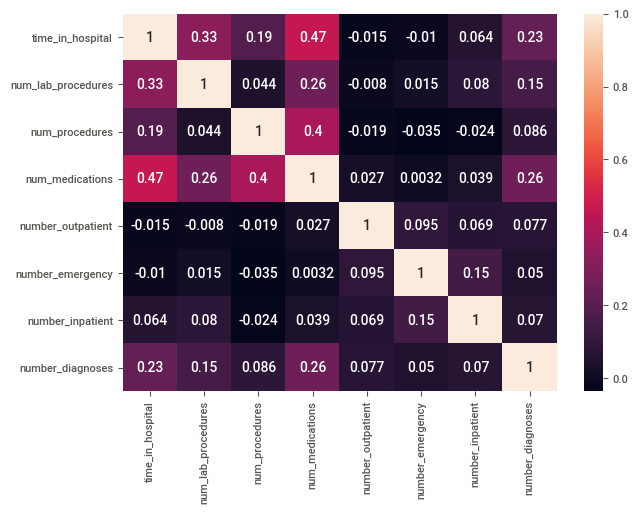

In [331]:
#Matriz de correlaciones entre las variables numéricas
plt.figure(figsize = (7,5))
sns.heatmap(data[var_num].corr(), annot = True)

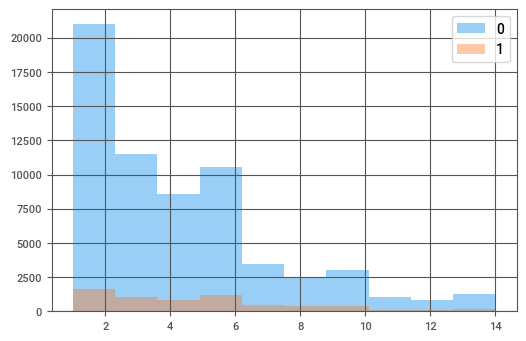

In [335]:
#Gráfico de distribución del número de días en el hospital para cada resultado del tratamiento
groups = data.groupby("readmitted")['time_in_hospital']

fig, ax = plt.subplots()

for k, v in groups:
    v.hist(label=k, alpha=.4, ax=ax)

ax.legend()

## Modelación

Se define nuestro target, como también las variables predictoras nominales, binarias y numéricas:

In [339]:
data.set_index('patient_nbr', inplace = True)

In [469]:
data.head(2)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
patient_nbr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8222157,Caucasian,Female,menores_40,Other,Other,Phys_clinic_referral,1.0,41.0,0.0,1.0,0.0,0.0,0.0,diabetes,other,other,1.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0,0
55629189,Caucasian,Female,menores_40,Emergency,Discharged_home,Emergency_room,3.0,59.0,0.0,18.0,0.0,0.0,0.0,other,diabetes,other,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,1,1,0


In [489]:
y= ['readmitted']

var_binarias = ['change',
 'diabetesMed']


var_nominales = [
 'race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'diag_1',
 'max_glu_serum',
 'A1Cresult',
 'insulin'  
]

# Se dejan por fuera ´porque definitivamente provocaron mucho ruido en las iteraciones

var_nominales_porfuera = ['diag_2',
'diag_3',
'metformin',
'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone'    
  ]

var_cualitativas = var_binarias + var_nominales

remove = var_cualitativas + y + var_nominales_porfuera

In [490]:
var_numericas = data.drop(remove,axis=1).columns.to_list()

In [491]:
var_numericas

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

Se utiliza el encoding one-hot para tratar las variables nominales y crear las dummies

In [492]:
"""
Encoding one-hot, transform to dummies the qualitative features
"""
df_cat_one_hot = pd.get_dummies(data[var_cualitativas])

In [493]:
df_cat_one_hot.head()

,change,diabetesMed,race_AfricanAmerican,race_Caucasian,race_Other,race_missing,gender_Female,gender_Male,age_80_mas,age_entre_40_60,age_entre_60_80,age_menores_40,admission_type_id_Elective,admission_type_id_Emergency,admission_type_id_Other,discharge_disposition_id_Discharged_home,discharge_disposition_id_Other,admission_source_id_Emergency_room,admission_source_id_Other,admission_source_id_Phys_clinic_referral,diag_1_circulatory,diag_1_diabetes,diag_1_digestive,diag_1_genitourinary,diag_1_injury,diag_1_musculoskeletal,diag_1_other,diag_1_respiratory,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
patient_nbr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8222157,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
55629189,1,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
86047875,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
82442376,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
42519267,1,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0


In [494]:
#Elimino una variable del 'género' para no tener binarias redundantes, igual que una del campo 'discharge_disposition_id'
df_cat_one_hot.drop(['gender_Male', 'discharge_disposition_id_Other'], axis = 1, inplace = True)

In [495]:
#Uno todas las variables que utilizaré para modelación
"""
Join all features
"""
X = pd.concat([data[var_numericas], df_cat_one_hot], axis=1)

In [496]:
X.shape

(69973, 46)

In [497]:
# Codificación de la variable de respuesta
y=data[y]
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

In [498]:
# Partición de los datos en Train y Test (80/20)
seed = 123
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y, test_size=test_size, random_state=seed)

In [499]:
X_test.shape

(13995, 46)

In [500]:
X_train.shape

(55978, 46)

### Se ajusta un modelo de clasificación utilizando el algoritmo XGBoost


In [501]:
#Grid Search para buscar los mejores hiperparámetros

x_train, y_train, x_valid, y_valid =  X_train, y_train, X_test, y_test

clf = xgb.XGBClassifier()

param_grid = {
        'max_depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'n_estimators': [100, 200, 300]}

fit_params = {'eval_metric': 'mlogloss',
              'early_stopping_rounds': 10,
              'eval_set': [(x_valid, y_valid)]}

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                            n_jobs=1, verbose=2, cv=2,
                            scoring= {'acc': 'accuracy',
                           'recall': 'recall', 'neg_log_loss': 'neg_log_loss'}, refit= 'neg_log_loss', random_state=42)


print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(x_train, y_train)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] n_estimators=200, min_child_weight=5.0, max_depth=8, learning_rate=0.3, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_child_weight=5.0, max_depth=8, learning_rate=0.3, colsample_bytree=0.7, total=   5.5s
[CV] n_estimators=200, min_child_weight=5.0, max_depth=8, learning_rate=0.3, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV]  n_estimators=200, min_child_weight=5.0, max_depth=8, learning_rate=0.3, colsample_bytree=0.7, total=   5.4s
[CV] n_estimators=200, min_child_weight=0.5, max_depth=6, learning_rate=0.01, colsample_bytree=0.9 
[CV]  n_estimators=200, min_child_weight=0.5, max_depth=6, learning_rate=0.01, colsample_bytree=0.9, total=   5.2s
[CV] n_estimators=200, min_child_weight=0.5, max_depth=6, learning_rate=0.01, colsample_bytree=0.9 
[CV]  n_estimators=200, min_child_weight=0.5, max_depth=6, learning_rate=0.01, colsample_bytree=0.9, total=   5.0s
[CV] n_estimators=300, min_child_weight=7.0, max_depth=10, learning_rate=0.3, colsample_bytree=0.6 
[CV]  n_estimators=300, min_child_weight=7.0, max_depth=10, learning_rate=0.3, colsample_bytree=0.6, total=   8.9s
[CV] n_estimators=300, min_child_weight=7.0, max_depth=10, learning_rate=0.3, colsample_bytree=0.6 
[CV]  n_estimators=300, min_child_weight=7.0, max_depth=10, learning_rate=0.3, colsample_bytree=0.6, total=   8.6s
[CV] n_estimators=200, min

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.3min finished


Randomized search time: 198.28309082984924
Best score: -0.2946501302389205
Best params: 
colsample_bytree: 0.4
learning_rate: 0.1
max_depth: 4
min_child_weight: 10.0
n_estimators: 100


In [508]:
# Se ajusta un modelo de clasificación utilizando el algoritmo de XGBoosting
model = XGBClassifier(n_jobs=-1, seed=seed)
#model = XGBClassifier(n_jobs=-1, seed=seed, learning_rate = 0.1, max_depth = 4, n_estimators = 100, 
#                      colsample_bytree = 0.4, min_child_weight = 10)
model.fit(X_train, y_train)
print(model)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [509]:
# realizamos predicciones con la base de entrenamiento para comparar las metricas de entrenamiento con las de test
y_train_pred = model.predict(X_train)

In [511]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     12775
           1       0.20      0.01      0.01      1220

    accuracy                           0.91     13995
   macro avg       0.55      0.50      0.48     13995
weighted avg       0.85      0.91      0.87     13995



In [510]:
#Matriz de confusión
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[12738    37]
 [ 1211     9]]


In [518]:
#Evaluamos predicciones
accuracy = accuracy_score(y_test, predictions)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision=precision_score(y_test, predictions)
precision_train=precision_score(y_train, y_train_pred)
recall=recall_score(y_test, predictions)
recall_train=recall_score(y_train, y_train_pred)
roc=roc_auc_score(y_test,predictions)
kappa = cohen_kappa_score(y_test,predictions)
kappa_train = cohen_kappa_score(y_train,y_train_pred)


print("AUC-ROC: %.2f%% " % (roc *100))
print("Precision (Test): %.2f%% " % (precision *100))
print("Precision (Train): %.2f%% " % (precision_train *100))
print("Sensibilidad/Recall (Test): %.2f%% " % (recall * 100))
print("Sensibilidad/Recall (Train):  %.2f%%" % (recall_train * 100))
print("Kappa (Test): " , (kappa))
print("Kappa (Train):  " , (kappa_train))
print("Accuracy (Test): %.2f%% " % (accuracy * 100.0))
print("Accuracy (Train): %.2f%% " % (accuracy_train * 100.0))
print("Especificidad: %.2f%% " % round(cf_matrix[0,0]/cf_matrix[0,:].sum()*100,2) )


AUC-ROC: 50.22% 
Precision (Test): 19.57% 
Precision (Train): 99.40% 
Sensibilidad/Recall (Test): 0.74% 
Sensibilidad/Recall (Train):  6.60%
Kappa (Test):  0.007933347836434512
Kappa (Train):   0.11388951193008978
Accuracy (Test): 91.08% 
Accuracy (Train): 91.56% 
Especificidad: 99.71% 


Como estamos viendo, se ha obtenido un modelo con Accuracy del 91%, pero con datos desbalanceados como los evidenciamos es irrelevante concluir sobre esta métrica. Cuando observamos las métricas de mayor interés como el Recall, está muy pobre su rendimiento con el 0.74%, el modelo no esta siendo capaz de predecir a los pacientes que tuvieron readmisión. En general el performance del modelo no es acorde ni se ajusta a las expectativas lamentablemente. En este caso, **me gustaría discutir sobre esto**, puesto que en esta iteración no se ha logrado el objetivo. Se debe recalibrar el modelo, desde la preparación de datos o pensar en alguna alternativa con métodos que soporten o curen el desbalanceo en los datos.

In [516]:
#Función para plotear la matriz de confusión
#Créditos: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix - Visualización agradable de matriz de confusión
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


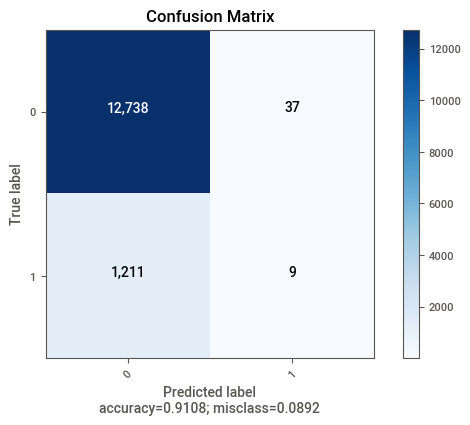

In [517]:
plot_confusion_matrix(cm           = cf_matrix, 
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix")

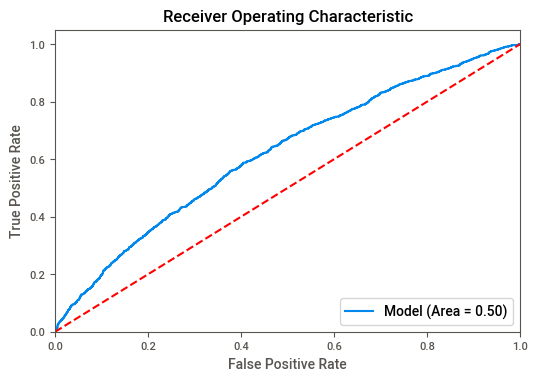

In [447]:
pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, pred_prob) 
plt.figure()
plt.plot(fpr, tpr, label='Model (Area = %0.2f)' % roc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC')
plt.show()

Como es de esperarse, el performance de la curva ROC no es el esperado, teniendo un AUC muy pobre.

### Importancia de variables

Se continúa el procedimiento, a pesar de los resultados, en un mejor escenario y con mejores parámetros se continuaría con la selección de variables mas importantes para tener un modelo parsimonioso.

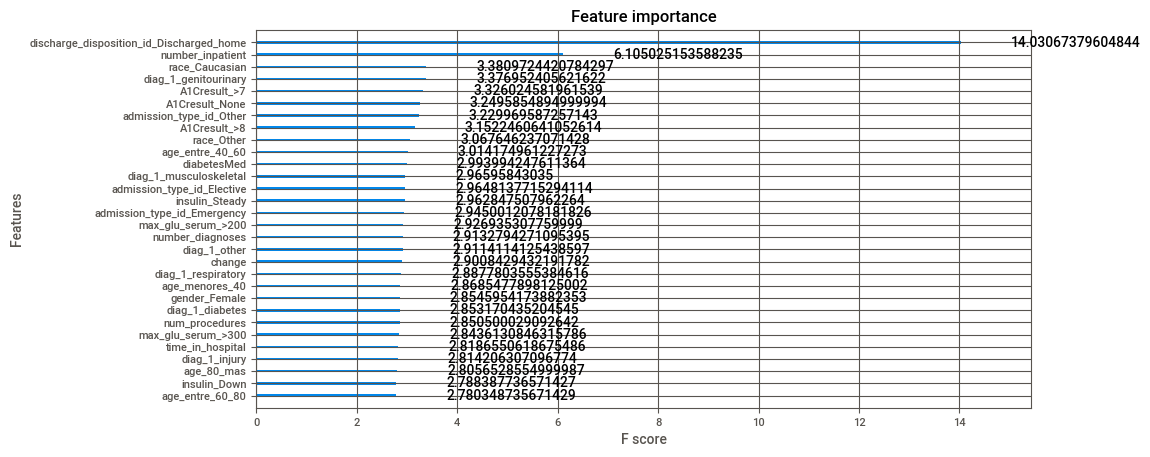

In [519]:
#Importance variable
ax = xgb.plot_importance(model, max_num_features =30, importance_type='gain')
fig = ax.figure
fig.set_size_inches(10, 5)

In [520]:
#Se extraen las de mayor importancia
importance = model.feature_importances_
variables = X.columns
var_imp = pd.concat([pd.Series(variables.values), pd.Series(importance)], axis=1)

In [521]:
var_imp.sort_values(by=1, ascending=False).head(10)

,0,1
22,discharge_disposition_id_Discharged_home,0.097501
6,number_inpatient,0.042425
11,race_Caucasian,0.023495
29,diag_1_genitourinary,0.023467
38,A1Cresult_>7,0.023113
40,A1Cresult_None,0.022582
21,admission_type_id_Other,0.022445
39,A1Cresult_>8,0.021905
12,race_Other,0.021317
16,age_entre_40_60,0.020946


In [522]:
vec_import_feat = var_imp.sort_values(by=1, ascending=False).head(10)
vec_import_feat[0].to_list()

['discharge_disposition_id_Discharged_home',
 'number_inpatient',
 'race_Caucasian',
 'diag_1_genitourinary',
 'A1Cresult_>7',
 'A1Cresult_None',
 'admission_type_id_Other',
 'A1Cresult_>8',
 'race_Other',
 'age_entre_40_60']

### SELECCIÓN DE VARIABLES

In [523]:
#importance_type = 'gain'
vec_import_feat = ['discharge_disposition_id_Discharged_home',
 'number_inpatient',
 'race_Caucasian',
 'diag_1_genitourinary',
 'A1Cresult_>7',
 'A1Cresult_None',
 'admission_type_id_Other',
 'A1Cresult_>8',
 'race_Other',
 'age_entre_40_60']
    

In [524]:
###Seleccion de variables en X
X_selected = X[vec_import_feat] 
print(X_selected.shape)
X_selected.head()

(69973, 10)


,discharge_disposition_id_Discharged_home,number_inpatient,race_Caucasian,diag_1_genitourinary,A1Cresult_>7,A1Cresult_None,admission_type_id_Other,A1Cresult_>8,race_Other,age_entre_40_60
patient_nbr,,,,,,,,,,
8222157,0,0.0,1,0,0,1,1,0,0,0
55629189,1,0.0,1,0,0,1,0,0,0,0
86047875,1,1.0,0,0,0,1,0,0,0,0
82442376,1,0.0,1,0,0,1,0,0,0,0
42519267,1,0.0,1,0,0,1,0,0,0,1


Se realiza de nuevo un ajuste con las variables seleccionadas

In [526]:
# split data into train and test sets
seed = 123
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X_selected, label_encoded_y, test_size=test_size, random_state=seed)
model = XGBClassifier(n_jobs=-1, seed=seed)

model.fit(X_train, y_train)
print(model)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [527]:
y_train_pred = model.predict(X_train)

In [528]:
#Evaluamos predicciones
accuracy = accuracy_score(y_test, predictions)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision=precision_score(y_test, predictions)
precision_train=precision_score(y_train, y_train_pred)
recall=recall_score(y_test, predictions)
recall_train=recall_score(y_train, y_train_pred)
roc=roc_auc_score(y_test,predictions)
kappa = cohen_kappa_score(y_test,predictions)
kappa_train = cohen_kappa_score(y_train,y_train_pred)


print("AUC-ROC: %.2f%% " % (roc *100))
print("Precision (Test): %.2f%% " % (precision *100))
print("Precision (Train): %.2f%% " % (precision_train *100))
print("Sensibilidad/Recall (Test): %.2f%% " % (recall * 100))
print("Sensibilidad/Recall (Train):  %.2f%%" % (recall_train * 100))
print("Kappa (Test): " , (kappa))
print("Kappa (Train):  " , (kappa_train))
print("Accuracy (Test): %.2f%% " % (accuracy * 100.0))
print("Accuracy (Train): %.2f%% " % (accuracy_train * 100.0))
print("Especificidad: %.2f%% " % round(cf_matrix[0,0]/cf_matrix[0,:].sum()*100,2) )

AUC-ROC: 50.11% 
Precision (Test): 23.53% 
Precision (Train): 76.79% 
Sensibilidad/Recall (Test): 0.33% 
Sensibilidad/Recall (Train):  0.85%
Kappa (Test):  0.004080986269229703
Kappa (Train):   0.01487042512609793
Accuracy (Test): 91.22% 
Accuracy (Train): 91.02% 
Especificidad: 99.71% 


Igualmente, la idea era tener un modelo parsimonioso, pero ante el mal performance obtenido en el modelo, siempre vamos a tener ese problema de las métricas tan bajas. Acontinuación se busca encontrar el treshold óptimo para mejorar las clasificaciones. **Me gustaría discutir esta parte** puesto que en mejores condiciones, con datos menos desbalanceados y con mejor performance del modelo, sería bueno este ejercicio, pero ante el mal escenario en el que estamos, me parece se forza mucha el modelo a los resultados que buscamos, y ese no es la mejor solución, como decía antes, debemos volver a la preparación de datos y a la recalibración del modelo (incluyendo cambio de método si es mejor).

In [529]:
y_pred = model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(tpr)
print(fpr)
print(thresholds)
print(roc_auc_score(y_test, y_pred))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

[0.00000000e+00 0.00000000e+00 8.19672131e-04 8.19672131e-04
 1.63934426e-03 1.63934426e-03 2.45901639e-03 2.45901639e-03
 3.27868852e-03 3.27868852e-03 3.27868852e-03 3.27868852e-03
 4.09836066e-03 4.09836066e-03 4.09836066e-03 4.91803279e-03
 4.91803279e-03 4.91803279e-03 4.91803279e-03 7.37704918e-03
 8.19672131e-03 8.19672131e-03 1.31147541e-02 1.47540984e-02
 1.55737705e-02 1.55737705e-02 1.55737705e-02 1.55737705e-02
 1.63934426e-02 1.72131148e-02 1.80327869e-02 1.80327869e-02
 1.80327869e-02 2.29508197e-02 3.68852459e-02 3.68852459e-02
 3.68852459e-02 3.68852459e-02 3.68852459e-02 3.68852459e-02
 3.68852459e-02 3.68852459e-02 3.85245902e-02 3.85245902e-02
 3.85245902e-02 3.85245902e-02 4.18032787e-02 4.34426230e-02
 4.42622951e-02 4.50819672e-02 4.50819672e-02 4.50819672e-02
 4.59016393e-02 4.67213115e-02 4.67213115e-02 5.08196721e-02
 5.08196721e-02 5.16393443e-02 5.16393443e-02 5.40983607e-02
 5.40983607e-02 5.57377049e-02 5.57377049e-02 5.65573770e-02
 5.65573770e-02 5.655737

### Modelo con threshold óptimo

In [530]:
model = XGBClassifier(n_jobs=-1, seed=seed)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:,1]
thresh =0.07165469
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
# evaluate predictions
recall = recall_score(y_test, y_pred)
print("recall: %.2f%%" % (recall * 100.0))

recall: 60.49%


In [531]:
y_train_pred = model.predict_proba(X_train)[:,1]
y_train_pred [y_train_pred > thresh] = 1
y_train_pred [y_train_pred <= thresh] = 0
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

In [532]:
cf_matrix

array([[7443, 5332],
       [ 482,  738]], dtype=int64)

In [535]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.58      0.72     12775
           1       0.12      0.60      0.20      1220

    accuracy                           0.58     13995
   macro avg       0.53      0.59      0.46     13995
weighted avg       0.87      0.58      0.67     13995



En este caso con el ajuste del threshold se mejora el recall al 60%, pero como mencioné antes, me gustaría **discutirlo** puesto que con el performance obtenido del modelo y el desbalanceo, estamos forzando al modelo a mejorar la clasificación.

## Conclusión final

Lamentablemente, los resultados no han sido los esperados pero con las soluciones planteadas anteriormente se pueden mejorar los resultados. Frente a las personas que puedan interesar la predicción de la readmisión temprana de pacientes a los hospitales, se podría **proponer una categorización de las probabilidades del output del modelo en baja, media y alta.** Con esta categorización se podría priorizar acciones sobre los pacientes con esas probabilidades altas y así mismo generar insights para los hospitales y mejorar la readmisión temprana, junto con costos y temas operativos que conlleva esta situación.